In [1]:
%matplotlib inline

# DISPERSION ANALYSIS II
Author: Jordan Guerra (for Villanova University). May 2024.

This tutorial illustrates the more advanced use of the package *polBpy* for performing the angular dispersion analysis for studying the magnetoturbulent state of gas using dust polarimetric observations. Parameters determined can be used for DCF calculations.

This tutorial uses data from literature listed [here.](https://github.com/jorgueagui/polBpy/blob/9039d4af5d25c49130bf51be7fe0ce363424edcc/refs.md)

**EXAMPLE I**: This example shows how to perform detailed dispersion analysis for a masked region of gas. This analysis involves: i) calculating the autocorrelation function of the polarized flux, and measuring it width as estimation of the cloud's depnth; ii) calcualting a pixel-by-pixel two-point struture function by defining a circular kernel centered at each pixel;, ii) fitting the pixel-by-pixel two-point structure function with the two-scale model of Houde et. al. (2009, 2010) using a MCMC approach and determining the magnetotubrulent parameters. We reproduce here some results from Guerra et. al. (2021), which presents results of the OMC-1 region using multiwavelength observations of SOFIA/HAWC+.

In [2]:
import os
os.chdir(os.path.expanduser("/Users/jguerraa/Desktop/polBpy"))
from polBpy import dispersion, fitting
import numpy as np
import matplotlib.pyplot as plt

In this example we try to reproduce resukts from Guerra et. al. (2021). Specifically, reproducing the plots in Figure 3, which utilizes the 214-$\mu$m data from HAWC+. First, we calculate the $\Delta^{\prime}$ through the autocorrelation function. 

In [3]:
from astropy.io import fits
file = "/Users/jguerraa/Desktop/polBpy/tutorials/PolBpy_Tutorial_IV_data.fits"
data = fits.open(file)
print(data.info())

Filename: /Users/jguerraa/Desktop/polBpy/tutorials/PolBpy_Tutorial_IV_data.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  STOKES I      1 PrimaryHDU     597   (102, 114)   float64   
  1  ERROR I       1 ImageHDU        27   (102, 114)   float64   
  2  STOKES Q      1 ImageHDU        18   (102, 114)   float64   
  3  ERROR Q       1 ImageHDU        18   (102, 114)   float64   
  4  STOKES U      1 ImageHDU        18   (102, 114)   float64   
  5  ERROR U       1 ImageHDU        18   (102, 114)   float64   
  6  IMAGE MASK    1 ImageHDU        27   (102, 114)   float64   
  7  PERCENT POL    1 ImageHDU        18   (102, 114)   float64   
  8  DEBIASED PERCENT POL    1 ImageHDU        18   (102, 114)   float64   
  9  ERROR PERCENT POL    1 ImageHDU        18   (102, 114)   float64   
 10  POL ANGLE     1 ImageHDU        18   (102, 114)   float64   
 11  ROTATED POL ANGLE    1 ImageHDU        18   (102, 114)   float64   
 12  ERROR POL ANGLE    1 ImageHDU       

First, we exclude the points with p/p_err > 3.0
by creating a mask,

In [4]:
p_flux = data['DEBIASED POL FLUX'].data # 
p_flux_err = data['ERROR POL FLUX'].data #
pixel_size = data[0].header['CDELT2']*3600 #in arcsec
# Find the points
m = np.where(p_flux/p_flux_err > 3.0)
# Create the mask
mask = np.full_like(p_flux,0.0)
mask[m] = 1.0

Now we call the autocorrelation function (for further details on this function see Tutorial III),

In [5]:
res = dispersion.autocorrelation(p_flux,p_flux_err,pixsize=pixel_size,mask=mask,plots=False,hwhm=True)

And print the $\Delta^{\prime}$ in the (multiple of) units of pixel_size

In [6]:
print("Delta' = %2.2f +/- %2.2f [arcmin]"%(res[0],res[1]))

Delta' = 1.55 +/- 0.12 [arcmin]


In order to calculate the map of dispersion functions, we need to define the relevant variables

In [7]:
angles = data['ROTATED POL ANGLE'].data # km/s
angles_err = data['ERROR POL ANGLE'].data # km/s
beam_s = 4*pixel_size # FWHM value of the beam
win_s = 9 # pixel

In [8]:
res1 = dispersion.dispersion_function_map(angles,angles_err,pixel_size,mask=mask,beam=beam_s,w=win_s,verbose=False)

Analysis window size =  19 x 19
Skipping Pixel = 9 9
Skipping Pixel = 9 10
Skipping Pixel = 9 11
Skipping Pixel = 9 12
Skipping Pixel = 9 13
Skipping Pixel = 9 14
Skipping Pixel = 9 15
Skipping Pixel = 9 16
Skipping Pixel = 9 17
Skipping Pixel = 9 18
Skipping Pixel = 9 19
Skipping Pixel = 9 20
Skipping Pixel = 9 21
Skipping Pixel = 9 22
Skipping Pixel = 9 23
Skipping Pixel = 9 24
Skipping Pixel = 9 25
Skipping Pixel = 9 26
Skipping Pixel = 9 27
Skipping Pixel = 9 28
Skipping Pixel = 9 29
Skipping Pixel = 9 30
Skipping Pixel = 9 31
Skipping Pixel = 9 32
Skipping Pixel = 9 33
Skipping Pixel = 9 34
Skipping Pixel = 9 35
Calculating Function for Pixel =  9 36
Percent: [----------] 2.786377708978328%  
Calculating Function for Pixel =  9 37
Percent: [----------] 2.863777089783282%  
Calculating Function for Pixel =  9 38
Percent: [----------] 2.941176470588235%  
Calculating Function for Pixel =  9 39
Percent: [----------] 3.018575851393189%  
Calculating Function for Pixel =  9 40
Percent:

/Users/jguerraa/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jguerraa/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jguerraa/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jguerraa/Desktop/polBpy/polBpy/utils.py:94: RuntimeWarning: Mean of empty slice
  rms = np.sqrt(np.nanmean(vec**2))
/Users/jguerraa/Desktop/polBpy/polBpy/dispersion.py:141: RuntimeWarning: invalid value encountered in sqrt
  errors_c[i]= np.sqrt( (sinDphisum[i]**2)*sigma2sum[i] + (sinDphisum[i]**2)*Dphisum[i] + \
/Users/jguerraa/Desktop/polBpy/polBpy/utils.py:98: RuntimeWarning: invalid value enc

Calculating Function for Pixel =  9 52
Percent: [----------] 4.024767801857585%  
Calculating Function for Pixel =  9 53
Percent: [----------] 4.102167182662539%  
Calculating Function for Pixel =  9 54
Percent: [----------] 4.179566563467492%  
Calculating Function for Pixel =  9 55
Percent: [----------] 4.256965944272446%  
Skipping Pixel = 9 56
Skipping Pixel = 9 57
Calculating Function for Pixel =  9 58
Percent: [----------] 4.489164086687306%  
Calculating Function for Pixel =  9 59
Percent: [----------] 4.56656346749226%  
Calculating Function for Pixel =  9 60
Percent: [----------] 4.643962848297214%  
Calculating Function for Pixel =  9 61
Percent: [----------] 4.721362229102167%  
Calculating Function for Pixel =  9 62
Percent: [----------] 4.798761609907121%  
Calculating Function for Pixel =  9 63
Percent: [----------] 4.876160990712075%  
Calculating Function for Pixel =  9 64
Percent: [----------] 4.953560371517028%  
Calculating Function for Pixel =  9 65
Percent: [#-----

Percent: [----------] 2.17578259373925%  
Calculating Function for Pixel =  11 24
Percent: [----------] 2.2703818369453046%  
Calculating Function for Pixel =  11 25
Percent: [----------] 2.3649810801513587%  
Calculating Function for Pixel =  11 26
Percent: [----------] 2.459580323357413%  
Calculating Function for Pixel =  11 27
Percent: [----------] 2.5541795665634677%  
Calculating Function for Pixel =  11 28
Percent: [----------] 2.6487788097695217%  
Calculating Function for Pixel =  11 29
Percent: [----------] 2.7433780529755762%  
Calculating Function for Pixel =  11 30
Percent: [----------] 2.8379772961816303%  
Skipping Pixel = 11 31
Skipping Pixel = 11 32
Skipping Pixel = 11 33
Skipping Pixel = 11 34
Calculating Function for Pixel =  11 35
Percent: [----------] 3.3109735122119024%  
Calculating Function for Pixel =  11 36
Percent: [----------] 3.4055727554179565%  
Calculating Function for Pixel =  11 37
Percent: [----------] 3.500171998624011%  
Calculating Function for Pix

Percent: [#---------] 6.29514963880289%  
Calculating Function for Pixel =  12 62
Percent: [#---------] 6.398348813209494%  
Calculating Function for Pixel =  12 63
Percent: [#---------] 6.5015479876160995%  
Calculating Function for Pixel =  12 64
Percent: [#---------] 6.604747162022703%  
Calculating Function for Pixel =  12 65
Percent: [#---------] 6.707946336429309%  
Calculating Function for Pixel =  12 66
Percent: [#---------] 6.811145510835913%  
Calculating Function for Pixel =  12 67
Percent: [#---------] 6.9143446852425186%  
Calculating Function for Pixel =  12 68
Percent: [#---------] 7.017543859649122%  
Calculating Function for Pixel =  12 69
Percent: [#---------] 7.120743034055728%  
Calculating Function for Pixel =  12 70
Percent: [#---------] 7.223942208462332%  
Calculating Function for Pixel =  12 71
Percent: [#---------] 7.327141382868938%  
Calculating Function for Pixel =  12 72
Percent: [#---------] 7.430340557275541%  
Calculating Function for Pixel =  12 73
Per

Percent: [----------] 3.7323701410388717%  
Calculating Function for Pixel =  14 32
Percent: [----------] 3.8527691778465774%  
Calculating Function for Pixel =  14 33
Percent: [----------] 3.973168214654283%  
Calculating Function for Pixel =  14 34
Percent: [----------] 4.093567251461988%  
Calculating Function for Pixel =  14 35
Percent: [----------] 4.2139662882696935%  
Calculating Function for Pixel =  14 36
Percent: [----------] 4.3343653250774%  
Calculating Function for Pixel =  14 37
Percent: [----------] 4.454764361885105%  
Calculating Function for Pixel =  14 38
Percent: [----------] 4.57516339869281%  
Calculating Function for Pixel =  14 39
Percent: [----------] 4.695562435500515%  
Calculating Function for Pixel =  14 40
Percent: [----------] 4.815961472308222%  
Calculating Function for Pixel =  14 41
Percent: [----------] 4.936360509115927%  
Calculating Function for Pixel =  14 42
Percent: [#---------] 5.056759545923633%  
Calculating Function for Pixel =  14 43
Perc

Percent: [#---------] 8.90092879256966%  
Calculating Function for Pixel =  15 70
Percent: [#---------] 9.029927760577916%  
Calculating Function for Pixel =  15 71
Percent: [#---------] 9.158926728586172%  
Calculating Function for Pixel =  15 72
Percent: [#---------] 9.287925696594428%  
Calculating Function for Pixel =  15 73
Percent: [#---------] 9.416924664602682%  
Calculating Function for Pixel =  15 74
Percent: [#---------] 9.54592363261094%  
Calculating Function for Pixel =  15 75
Percent: [#---------] 9.674922600619196%  
Calculating Function for Pixel =  15 76
Percent: [#---------] 9.803921568627452%  
Skipping Pixel = 15 77
Skipping Pixel = 15 78
Skipping Pixel = 15 79
Skipping Pixel = 15 80
Calculating Function for Pixel =  15 81
Percent: [#---------] 10.448916408668731%  
Calculating Function for Pixel =  15 82
Percent: [#---------] 10.577915376676987%  
Calculating Function for Pixel =  15 83
Percent: [#---------] 10.706914344685242%  
Calculating Function for Pixel =  

Calculating Function for Pixel =  17 37
Percent: [#---------] 5.409356725146199%  
Calculating Function for Pixel =  17 38
Percent: [#---------] 5.555555555555555%  
Calculating Function for Pixel =  17 39
Percent: [#---------] 5.701754385964912%  
Calculating Function for Pixel =  17 40
Percent: [#---------] 5.847953216374268%  
Calculating Function for Pixel =  17 41
Percent: [#---------] 5.994152046783626%  
Calculating Function for Pixel =  17 42
Percent: [#---------] 6.140350877192982%  
Calculating Function for Pixel =  17 43
Percent: [#---------] 6.286549707602338%  
Calculating Function for Pixel =  17 44
Percent: [#---------] 6.432748538011696%  
Calculating Function for Pixel =  17 45
Percent: [#---------] 6.578947368421052%  
Calculating Function for Pixel =  17 46
Percent: [#---------] 6.725146198830409%  
Calculating Function for Pixel =  17 47
Percent: [#---------] 6.871345029239766%  
Calculating Function for Pixel =  17 48
Percent: [#---------] 7.017543859649122%  
Calc

Calculating Function for Pixel =  18 65
Percent: [#---------] 10.061919504643962%  
Calculating Function for Pixel =  18 66
Percent: [#---------] 10.21671826625387%  
Calculating Function for Pixel =  18 67
Percent: [#---------] 10.371517027863778%  
Calculating Function for Pixel =  18 68
Percent: [#---------] 10.526315789473683%  
Calculating Function for Pixel =  18 69
Percent: [#---------] 10.68111455108359%  
Calculating Function for Pixel =  18 70
Percent: [#---------] 10.8359133126935%  
Calculating Function for Pixel =  18 71
Percent: [#---------] 10.990712074303406%  
Calculating Function for Pixel =  18 72
Percent: [#---------] 11.145510835913312%  
Calculating Function for Pixel =  18 73
Percent: [#---------] 11.30030959752322%  
Calculating Function for Pixel =  18 74
Percent: [#---------] 11.455108359133128%  
Calculating Function for Pixel =  18 75
Percent: [#---------] 11.609907120743033%  
Calculating Function for Pixel =  18 76
Percent: [#---------] 11.76470588235294% 

Percent: [#---------] 14.215686274509803%  
Calculating Function for Pixel =  19 88
Percent: [#---------] 14.37908496732026%  
Calculating Function for Pixel =  19 89
Percent: [#---------] 14.54248366013072%  
Skipping Pixel = 19 90
Skipping Pixel = 19 91
Skipping Pixel = 19 92
Skipping Pixel = 20 9
Skipping Pixel = 20 10
Skipping Pixel = 20 11
Skipping Pixel = 20 12
Skipping Pixel = 20 13
Skipping Pixel = 20 14
Calculating Function for Pixel =  20 15
Percent: [----------] 2.5799793601651184%  
Calculating Function for Pixel =  20 16
Percent: [----------] 2.7519779841761265%  
Calculating Function for Pixel =  20 17
Percent: [----------] 2.923976608187134%  
Calculating Function for Pixel =  20 18
Percent: [----------] 3.0959752321981426%  
Calculating Function for Pixel =  20 19
Percent: [----------] 3.2679738562091507%  
Calculating Function for Pixel =  20 20
Percent: [----------] 3.4399724802201583%  
Calculating Function for Pixel =  20 21
Percent: [----------] 3.611971104231166% 

Percent: [#---------] 5.779153766769865%  
Calculating Function for Pixel =  21 33
Percent: [#---------] 5.959752321981425%  
Calculating Function for Pixel =  21 34
Percent: [#---------] 6.140350877192982%  
Calculating Function for Pixel =  21 35
Percent: [#---------] 6.32094943240454%  
Calculating Function for Pixel =  21 36
Percent: [#---------] 6.5015479876160995%  
Calculating Function for Pixel =  21 37
Percent: [#---------] 6.682146542827658%  
Calculating Function for Pixel =  21 38
Percent: [#---------] 6.862745098039216%  
Calculating Function for Pixel =  21 39
Percent: [#---------] 7.043343653250774%  
Calculating Function for Pixel =  21 40
Percent: [#---------] 7.223942208462332%  
Calculating Function for Pixel =  21 41
Percent: [#---------] 7.40454076367389%  
Calculating Function for Pixel =  21 42
Percent: [#---------] 7.5851393188854495%  
Calculating Function for Pixel =  21 43
Percent: [#---------] 7.765737874097008%  
Calculating Function for Pixel =  21 44
Perc

Percent: [#---------] 9.838321293429653%  
Calculating Function for Pixel =  22 53
Percent: [#---------] 10.02751977984176%  
Calculating Function for Pixel =  22 54
Percent: [#---------] 10.21671826625387%  
Calculating Function for Pixel =  22 55
Percent: [#---------] 10.405916752665979%  
Calculating Function for Pixel =  22 56
Percent: [#---------] 10.595115239078087%  
Calculating Function for Pixel =  22 57
Percent: [#---------] 10.784313725490197%  
Calculating Function for Pixel =  22 58
Percent: [#---------] 10.973512211902305%  
Calculating Function for Pixel =  22 59
Percent: [#---------] 11.162710698314413%  
Calculating Function for Pixel =  22 60
Percent: [#---------] 11.351909184726521%  
Calculating Function for Pixel =  22 61
Percent: [#---------] 11.541107671138631%  
Calculating Function for Pixel =  22 62
Percent: [#---------] 11.73030615755074%  
Calculating Function for Pixel =  22 63
Percent: [#---------] 11.91950464396285%  
Calculating Function for Pixel =  22 

Calculating Function for Pixel =  23 70
Percent: [#---------] 13.845889232886138%  
Calculating Function for Pixel =  23 71
Percent: [#---------] 14.043687650498796%  
Calculating Function for Pixel =  23 72
Percent: [#---------] 14.241486068111456%  
Calculating Function for Pixel =  23 73
Percent: [#---------] 14.439284485724112%  
Calculating Function for Pixel =  23 74
Percent: [#---------] 14.637082903336774%  
Calculating Function for Pixel =  23 75
Percent: [#---------] 14.834881320949433%  
Calculating Function for Pixel =  23 76
Percent: [##--------] 15.032679738562091%  
Calculating Function for Pixel =  23 77
Percent: [##--------] 15.230478156174751%  
Calculating Function for Pixel =  23 78
Percent: [##--------] 15.428276573787409%  
Skipping Pixel = 23 79
Calculating Function for Pixel =  23 80
Percent: [##--------] 15.823873409012728%  
Calculating Function for Pixel =  23 81
Percent: [##--------] 16.021671826625386%  
Calculating Function for Pixel =  23 82
Percent: [##-

Skipping Pixel = 24 90
Skipping Pixel = 24 91
Skipping Pixel = 24 92
Calculating Function for Pixel =  25 9
Percent: [----------] 1.9349845201238391%  
Calculating Function for Pixel =  25 10
Percent: [----------] 2.149982800137599%  
Calculating Function for Pixel =  25 11
Percent: [----------] 2.3649810801513587%  
Calculating Function for Pixel =  25 12
Percent: [----------] 2.5799793601651184%  
Skipping Pixel = 25 13
Skipping Pixel = 25 14
Skipping Pixel = 25 15
Calculating Function for Pixel =  25 16
Percent: [----------] 3.4399724802201583%  
Calculating Function for Pixel =  25 17
Percent: [----------] 3.654970760233918%  
Calculating Function for Pixel =  25 18
Percent: [----------] 3.8699690402476783%  
Calculating Function for Pixel =  25 19
Percent: [----------] 4.084967320261438%  
Calculating Function for Pixel =  25 20
Percent: [----------] 4.299965600275198%  
Calculating Function for Pixel =  25 21
Percent: [----------] 4.514963880288958%  
Calculating Function for Pix

Calculating Function for Pixel =  26 32
Percent: [#---------] 7.15514275885793%  
Calculating Function for Pixel =  26 33
Percent: [#---------] 7.37874097007224%  
Calculating Function for Pixel =  26 34
Percent: [#---------] 7.602339181286549%  
Calculating Function for Pixel =  26 35
Percent: [#---------] 7.825937392500861%  
Calculating Function for Pixel =  26 36
Percent: [#---------] 8.04953560371517%  
Calculating Function for Pixel =  26 37
Percent: [#---------] 8.27313381492948%  
Calculating Function for Pixel =  26 38
Percent: [#---------] 8.49673202614379%  
Calculating Function for Pixel =  26 39
Percent: [#---------] 8.720330237358102%  
Calculating Function for Pixel =  26 40
Percent: [#---------] 8.94392844857241%  
Calculating Function for Pixel =  26 41
Percent: [#---------] 9.167526659786722%  
Calculating Function for Pixel =  26 42
Percent: [#---------] 9.39112487100103%  
Calculating Function for Pixel =  26 43
Percent: [#---------] 9.614723082215344%  
Calculating

Calculating Function for Pixel =  27 53
Percent: [#---------] 12.306501547987617%  
Calculating Function for Pixel =  27 54
Percent: [#---------] 12.538699690402478%  
Calculating Function for Pixel =  27 55
Percent: [#---------] 12.770897832817338%  
Calculating Function for Pixel =  27 56
Percent: [#---------] 13.003095975232199%  
Calculating Function for Pixel =  27 57
Percent: [#---------] 13.23529411764706%  
Calculating Function for Pixel =  27 58
Percent: [#---------] 13.46749226006192%  
Calculating Function for Pixel =  27 59
Percent: [#---------] 13.69969040247678%  
Calculating Function for Pixel =  27 60
Percent: [#---------] 13.93188854489164%  
Calculating Function for Pixel =  27 61
Percent: [#---------] 14.1640866873065%  
Calculating Function for Pixel =  27 62
Percent: [#---------] 14.396284829721361%  
Calculating Function for Pixel =  27 63
Percent: [#---------] 14.628482972136222%  
Calculating Function for Pixel =  27 64
Percent: [#---------] 14.860681114551083% 

Calculating Function for Pixel =  28 76
Percent: [##--------] 18.30065359477124%  
Calculating Function for Pixel =  28 77
Percent: [##--------] 18.541451668386653%  
Calculating Function for Pixel =  28 78
Percent: [##--------] 18.78224974200206%  
Calculating Function for Pixel =  28 79
Percent: [##--------] 19.023047815617474%  
Skipping Pixel = 28 80
Skipping Pixel = 28 81
Calculating Function for Pixel =  28 82
Percent: [##--------] 19.745442036463707%  
Calculating Function for Pixel =  28 83
Percent: [##--------] 19.98624011007912%  
Calculating Function for Pixel =  28 84
Percent: [##--------] 20.227038183694532%  
Skipping Pixel = 28 85
Skipping Pixel = 28 86
Skipping Pixel = 28 87
Skipping Pixel = 28 88
Skipping Pixel = 28 89
Skipping Pixel = 28 90
Skipping Pixel = 28 91
Skipping Pixel = 28 92
Skipping Pixel = 29 9
Skipping Pixel = 29 10
Calculating Function for Pixel =  29 11
Percent: [----------] 2.7433780529755762%  
Calculating Function for Pixel =  29 12
Percent: [------

Percent: [----------] 4.901960784313726%  
Skipping Pixel = 30 20
Calculating Function for Pixel =  30 21
Percent: [#---------] 5.41795665634675%  
Calculating Function for Pixel =  30 22
Percent: [#---------] 5.675954592363261%  
Calculating Function for Pixel =  30 23
Percent: [#---------] 5.933952528379773%  
Calculating Function for Pixel =  30 24
Percent: [#---------] 6.191950464396285%  
Calculating Function for Pixel =  30 25
Percent: [#---------] 6.449948400412797%  
Calculating Function for Pixel =  30 26
Percent: [#---------] 6.707946336429309%  
Calculating Function for Pixel =  30 27
Percent: [#---------] 6.96594427244582%  
Calculating Function for Pixel =  30 28
Percent: [#---------] 7.223942208462332%  
Calculating Function for Pixel =  30 29
Percent: [#---------] 7.481940144478844%  
Calculating Function for Pixel =  30 30
Percent: [#---------] 7.739938080495357%  
Calculating Function for Pixel =  30 31
Percent: [#---------] 7.9979360165118685%  
Calculating Function f

Percent: [#---------] 10.130718954248366%  
Calculating Function for Pixel =  31 39
Percent: [#---------] 10.397316821465429%  
Calculating Function for Pixel =  31 40
Percent: [#---------] 10.66391468868249%  
Calculating Function for Pixel =  31 41
Percent: [#---------] 10.930512555899554%  
Calculating Function for Pixel =  31 42
Percent: [#---------] 11.197110423116616%  
Calculating Function for Pixel =  31 43
Percent: [#---------] 11.463708290333678%  
Calculating Function for Pixel =  31 44
Percent: [#---------] 11.73030615755074%  
Calculating Function for Pixel =  31 45
Percent: [#---------] 11.996904024767801%  
Calculating Function for Pixel =  31 46
Percent: [#---------] 12.263501891984864%  
Calculating Function for Pixel =  31 47
Percent: [#---------] 12.530099759201926%  
Calculating Function for Pixel =  31 48
Percent: [#---------] 12.796697626418988%  
Calculating Function for Pixel =  31 49
Percent: [#---------] 13.063295493636051%  
Calculating Function for Pixel =  

Calculating Function for Pixel =  32 60
Percent: [##--------] 16.51186790505676%  
Calculating Function for Pixel =  32 61
Percent: [##--------] 16.787065703474372%  
Calculating Function for Pixel =  32 62
Percent: [##--------] 17.062263501891987%  
Calculating Function for Pixel =  32 63
Percent: [##--------] 17.3374613003096%  
Calculating Function for Pixel =  32 64
Percent: [##--------] 17.61265909872721%  
Calculating Function for Pixel =  32 65
Percent: [##--------] 17.88785689714482%  
Calculating Function for Pixel =  32 66
Percent: [##--------] 18.163054695562437%  
Calculating Function for Pixel =  32 67
Percent: [##--------] 18.43825249398005%  
Calculating Function for Pixel =  32 68
Percent: [##--------] 18.71345029239766%  
Calculating Function for Pixel =  32 69
Percent: [##--------] 18.988648090815275%  
Calculating Function for Pixel =  32 70
Percent: [##--------] 19.263845889232886%  
Calculating Function for Pixel =  32 71
Percent: [##--------] 19.539043687650498%  

Calculating Function for Pixel =  33 83
Percent: [##--------] 23.555211558307533%  
Calculating Function for Pixel =  33 84
Percent: [##--------] 23.8390092879257%  
Calculating Function for Pixel =  33 85
Percent: [##--------] 24.12280701754386%  
Calculating Function for Pixel =  33 86
Percent: [##--------] 24.40660474716202%  
Calculating Function for Pixel =  33 87
Percent: [##--------] 24.690402476780186%  
Calculating Function for Pixel =  33 88
Percent: [##--------] 24.974200206398347%  
Calculating Function for Pixel =  33 89
Percent: [###-------] 25.257997936016512%  
Skipping Pixel = 33 90
Skipping Pixel = 33 91
Skipping Pixel = 33 92
Skipping Pixel = 34 9
Calculating Function for Pixel =  34 10
Percent: [----------] 2.923976608187134%  
Calculating Function for Pixel =  34 11
Percent: [----------] 3.216374269005848%  
Skipping Pixel = 34 12
Skipping Pixel = 34 13
Calculating Function for Pixel =  34 14
Percent: [----------] 4.093567251461988%  
Calculating Function for Pixel

Calculating Function for Pixel =  35 19
Percent: [#---------] 5.718954248366013%  
Calculating Function for Pixel =  35 20
Percent: [#---------] 6.019951840385277%  
Calculating Function for Pixel =  35 21
Percent: [#---------] 6.32094943240454%  
Calculating Function for Pixel =  35 22
Percent: [#---------] 6.621947024423805%  
Calculating Function for Pixel =  35 23
Percent: [#---------] 6.922944616443069%  
Calculating Function for Pixel =  35 24
Percent: [#---------] 7.223942208462332%  
Calculating Function for Pixel =  35 25
Percent: [#---------] 7.524939800481596%  
Calculating Function for Pixel =  35 26
Percent: [#---------] 7.825937392500861%  
Calculating Function for Pixel =  35 27
Percent: [#---------] 8.126934984520123%  
Calculating Function for Pixel =  35 28
Percent: [#---------] 8.427932576539387%  
Calculating Function for Pixel =  35 29
Percent: [#---------] 8.728930168558652%  
Calculating Function for Pixel =  35 30
Percent: [#---------] 9.029927760577916%  
Calcu

Calculating Function for Pixel =  36 36
Percent: [#---------] 11.145510835913312%  
Calculating Function for Pixel =  36 37
Percent: [#---------] 11.455108359133128%  
Calculating Function for Pixel =  36 38
Percent: [#---------] 11.76470588235294%  
Calculating Function for Pixel =  36 39
Percent: [#---------] 12.074303405572756%  
Calculating Function for Pixel =  36 40
Percent: [#---------] 12.38390092879257%  
Calculating Function for Pixel =  36 41
Percent: [#---------] 12.693498452012383%  
Calculating Function for Pixel =  36 42
Percent: [#---------] 13.003095975232199%  
Calculating Function for Pixel =  36 43
Percent: [#---------] 13.312693498452013%  
Calculating Function for Pixel =  36 44
Percent: [#---------] 13.622291021671826%  
Calculating Function for Pixel =  36 45
Percent: [#---------] 13.93188854489164%  
Calculating Function for Pixel =  36 46
Percent: [#---------] 14.241486068111456%  
Calculating Function for Pixel =  36 47
Percent: [#---------] 14.55108359133126

Percent: [##--------] 16.54626762985896%  
Calculating Function for Pixel =  37 53
Percent: [##--------] 16.864465084279328%  
Calculating Function for Pixel =  37 54
Percent: [##--------] 17.18266253869969%  
Calculating Function for Pixel =  37 55
Percent: [##--------] 17.500859993120056%  
Calculating Function for Pixel =  37 56
Percent: [##--------] 17.81905744754042%  
Calculating Function for Pixel =  37 57
Percent: [##--------] 18.137254901960784%  
Calculating Function for Pixel =  37 58
Percent: [##--------] 18.455452356381148%  
Calculating Function for Pixel =  37 59
Percent: [##--------] 18.773649810801512%  
Calculating Function for Pixel =  37 60
Percent: [##--------] 19.09184726522188%  
Calculating Function for Pixel =  37 61
Percent: [##--------] 19.41004471964224%  
Calculating Function for Pixel =  37 62
Percent: [##--------] 19.728242174062608%  
Calculating Function for Pixel =  37 63
Percent: [##--------] 20.046439628482972%  
Calculating Function for Pixel =  37 

Percent: [##--------] 21.895424836601308%  
Calculating Function for Pixel =  38 68
Percent: [##--------] 22.22222222222222%  
Calculating Function for Pixel =  38 69
Percent: [##--------] 22.54901960784314%  
Calculating Function for Pixel =  38 70
Percent: [##--------] 22.875816993464053%  
Calculating Function for Pixel =  38 71
Percent: [##--------] 23.202614379084967%  
Calculating Function for Pixel =  38 72
Percent: [##--------] 23.52941176470588%  
Calculating Function for Pixel =  38 73
Percent: [##--------] 23.856209150326798%  
Calculating Function for Pixel =  38 74
Percent: [##--------] 24.18300653594771%  
Calculating Function for Pixel =  38 75
Percent: [##--------] 24.509803921568626%  
Calculating Function for Pixel =  38 76
Percent: [##--------] 24.836601307189543%  
Calculating Function for Pixel =  38 77
Percent: [###-------] 25.163398692810457%  
Calculating Function for Pixel =  38 78
Percent: [###-------] 25.49019607843137%  
Calculating Function for Pixel =  38 

Calculating Function for Pixel =  39 82
Percent: [###-------] 27.502579979360164%  
Calculating Function for Pixel =  39 83
Percent: [###-------] 27.83797729618163%  
Calculating Function for Pixel =  39 84
Percent: [###-------] 28.173374613003094%  
Calculating Function for Pixel =  39 85
Percent: [###-------] 28.50877192982456%  
Calculating Function for Pixel =  39 86
Percent: [###-------] 28.84416924664603%  
Calculating Function for Pixel =  39 87
Percent: [###-------] 29.17956656346749%  
Calculating Function for Pixel =  39 88
Percent: [###-------] 29.51496388028896%  
Calculating Function for Pixel =  39 89
Percent: [###-------] 29.850361197110427%  
Calculating Function for Pixel =  39 90
Percent: [###-------] 30.185758513931887%  
Calculating Function for Pixel =  39 91
Percent: [###-------] 30.521155830753354%  
Calculating Function for Pixel =  39 92
Percent: [###-------] 30.856553147574818%  
Calculating Function for Pixel =  40 9
Percent: [----------] 3.0959752321981426% 

Calculating Function for Pixel =  41 13
Percent: [----------] 4.583763329893361%  
Calculating Function for Pixel =  41 14
Percent: [----------] 4.936360509115927%  
Calculating Function for Pixel =  41 15
Percent: [#---------] 5.288957688338494%  
Calculating Function for Pixel =  41 16
Percent: [#---------] 5.64155486756106%  
Calculating Function for Pixel =  41 17
Percent: [#---------] 5.994152046783626%  
Calculating Function for Pixel =  41 18
Percent: [#---------] 6.3467492260061915%  
Calculating Function for Pixel =  41 19
Percent: [#---------] 6.699346405228758%  
Calculating Function for Pixel =  41 20
Percent: [#---------] 7.051943584451324%  
Calculating Function for Pixel =  41 21
Percent: [#---------] 7.40454076367389%  
Calculating Function for Pixel =  41 22
Percent: [#---------] 7.757137942896457%  
Calculating Function for Pixel =  41 23
Percent: [#---------] 8.109735122119023%  
Calculating Function for Pixel =  41 24
Percent: [#---------] 8.46233230134159%  
Calcul

Percent: [#---------] 10.8359133126935%  
Calculating Function for Pixel =  42 31
Percent: [#---------] 11.197110423116616%  
Calculating Function for Pixel =  42 32
Percent: [#---------] 11.55830753353973%  
Calculating Function for Pixel =  42 33
Percent: [#---------] 11.91950464396285%  
Calculating Function for Pixel =  42 34
Percent: [#---------] 12.280701754385964%  
Calculating Function for Pixel =  42 35
Percent: [#---------] 12.64189886480908%  
Calculating Function for Pixel =  42 36
Percent: [#---------] 13.003095975232199%  
Calculating Function for Pixel =  42 37
Percent: [#---------] 13.364293085655316%  
Calculating Function for Pixel =  42 38
Percent: [#---------] 13.725490196078432%  
Calculating Function for Pixel =  42 39
Percent: [#---------] 14.086687306501547%  
Calculating Function for Pixel =  42 40
Percent: [#---------] 14.447884416924664%  
Calculating Function for Pixel =  42 41
Percent: [#---------] 14.80908152734778%  
Calculating Function for Pixel =  42 4

Percent: [##--------] 17.380460956312348%  
Calculating Function for Pixel =  43 48
Percent: [##--------] 17.750257997936018%  
Calculating Function for Pixel =  43 49
Percent: [##--------] 18.120055039559684%  
Calculating Function for Pixel =  43 50
Percent: [##--------] 18.48985208118335%  
Calculating Function for Pixel =  43 51
Percent: [##--------] 18.859649122807017%  
Calculating Function for Pixel =  43 52
Percent: [##--------] 19.229446164430687%  
Calculating Function for Pixel =  43 53
Percent: [##--------] 19.59924320605435%  
Calculating Function for Pixel =  43 54
Percent: [##--------] 19.96904024767802%  
Calculating Function for Pixel =  43 55
Percent: [##--------] 20.338837289301686%  
Calculating Function for Pixel =  43 56
Percent: [##--------] 20.708634330925353%  
Calculating Function for Pixel =  43 57
Percent: [##--------] 21.07843137254902%  
Calculating Function for Pixel =  43 58
Percent: [##--------] 21.44822841417269%  
Calculating Function for Pixel =  43 

Percent: [##--------] 24.59580323357413%  
Calculating Function for Pixel =  44 66
Percent: [##--------] 24.974200206398347%  
Calculating Function for Pixel =  44 67
Percent: [###-------] 25.352597179222563%  
Calculating Function for Pixel =  44 68
Percent: [###-------] 25.730994152046783%  
Calculating Function for Pixel =  44 69
Percent: [###-------] 26.109391124871%  
Calculating Function for Pixel =  44 70
Percent: [###-------] 26.48778809769522%  
Calculating Function for Pixel =  44 71
Percent: [###-------] 26.86618507051944%  
Calculating Function for Pixel =  44 72
Percent: [###-------] 27.24458204334365%  
Calculating Function for Pixel =  44 73
Percent: [###-------] 27.62297901616787%  
Calculating Function for Pixel =  44 74
Percent: [###-------] 28.001375988992088%  
Calculating Function for Pixel =  44 75
Percent: [###-------] 28.379772961816307%  
Calculating Function for Pixel =  44 76
Percent: [###-------] 28.75816993464052%  
Calculating Function for Pixel =  44 77
P

Calculating Function for Pixel =  45 85
Percent: [###-------] 32.89473684210527%  
Calculating Function for Pixel =  45 86
Percent: [###-------] 33.28173374613003%  
Calculating Function for Pixel =  45 87
Percent: [###-------] 33.6687306501548%  
Calculating Function for Pixel =  45 88
Percent: [###-------] 34.05572755417957%  
Calculating Function for Pixel =  45 89
Percent: [###-------] 34.44272445820433%  
Calculating Function for Pixel =  45 90
Percent: [###-------] 34.82972136222911%  
Skipping Pixel = 45 91
Skipping Pixel = 45 92
Calculating Function for Pixel =  46 9
Percent: [----------] 3.560371517027864%  
Calculating Function for Pixel =  46 10
Percent: [----------] 3.955968352253182%  
Calculating Function for Pixel =  46 11
Percent: [----------] 4.3515651874785%  
Calculating Function for Pixel =  46 12
Percent: [----------] 4.747162022703819%  
Calculating Function for Pixel =  46 13
Percent: [#---------] 5.142758857929137%  
Calculating Function for Pixel =  46 14
Perce

Percent: [#---------] 7.275541795665634%  
Calculating Function for Pixel =  47 19
Percent: [#---------] 7.6797385620915035%  
Calculating Function for Pixel =  47 20
Percent: [#---------] 8.083935328517372%  
Calculating Function for Pixel =  47 21
Percent: [#---------] 8.488132094943241%  
Calculating Function for Pixel =  47 22
Percent: [#---------] 8.892328861369108%  
Calculating Function for Pixel =  47 23
Percent: [#---------] 9.296525627794978%  
Calculating Function for Pixel =  47 24
Percent: [#---------] 9.700722394220847%  
Calculating Function for Pixel =  47 25
Percent: [#---------] 10.104919160646714%  
Calculating Function for Pixel =  47 26
Percent: [#---------] 10.509115927072584%  
Calculating Function for Pixel =  47 27
Percent: [#---------] 10.913312693498451%  
Calculating Function for Pixel =  47 28
Percent: [#---------] 11.31750945992432%  
Calculating Function for Pixel =  47 29
Percent: [#---------] 11.72170622635019%  
Calculating Function for Pixel =  47 30


Percent: [#---------] 13.622291021671826%  
Calculating Function for Pixel =  48 34
Percent: [#---------] 14.035087719298245%  
Calculating Function for Pixel =  48 35
Percent: [#---------] 14.447884416924664%  
Calculating Function for Pixel =  48 36
Percent: [#---------] 14.860681114551083%  
Calculating Function for Pixel =  48 37
Percent: [##--------] 15.273477812177502%  
Calculating Function for Pixel =  48 38
Percent: [##--------] 15.686274509803921%  
Calculating Function for Pixel =  48 39
Percent: [##--------] 16.09907120743034%  
Calculating Function for Pixel =  48 40
Percent: [##--------] 16.51186790505676%  
Calculating Function for Pixel =  48 41
Percent: [##--------] 16.92466460268318%  
Calculating Function for Pixel =  48 42
Percent: [##--------] 17.3374613003096%  
Calculating Function for Pixel =  48 43
Percent: [##--------] 17.750257997936018%  
Calculating Function for Pixel =  48 44
Percent: [##--------] 18.163054695562437%  
Calculating Function for Pixel =  48 

Calculating Function for Pixel =  49 48
Percent: [##--------] 20.227038183694532%  
Calculating Function for Pixel =  49 49
Percent: [##--------] 20.6484348125215%  
Calculating Function for Pixel =  49 50
Percent: [##--------] 21.06983144134847%  
Calculating Function for Pixel =  49 51
Percent: [##--------] 21.49122807017544%  
Calculating Function for Pixel =  49 52
Percent: [##--------] 21.912624699002407%  
Calculating Function for Pixel =  49 53
Percent: [##--------] 22.33402132782938%  
Calculating Function for Pixel =  49 54
Percent: [##--------] 22.755417956656345%  
Calculating Function for Pixel =  49 55
Percent: [##--------] 23.176814585483317%  
Calculating Function for Pixel =  49 56
Percent: [##--------] 23.598211214310286%  
Calculating Function for Pixel =  49 57
Percent: [##--------] 24.019607843137255%  
Calculating Function for Pixel =  49 58
Percent: [##--------] 24.441004471964227%  
Calculating Function for Pixel =  49 59
Percent: [##--------] 24.862401100791192%

Percent: [###-------] 26.659786721706226%  
Calculating Function for Pixel =  50 63
Percent: [###-------] 27.089783281733748%  
Calculating Function for Pixel =  50 64
Percent: [###-------] 27.519779841761267%  
Calculating Function for Pixel =  50 65
Percent: [###-------] 27.949776401788785%  
Calculating Function for Pixel =  50 66
Percent: [###-------] 28.379772961816307%  
Calculating Function for Pixel =  50 67
Percent: [###-------] 28.809769521843826%  
Calculating Function for Pixel =  50 68
Percent: [###-------] 29.239766081871345%  
Calculating Function for Pixel =  50 69
Percent: [###-------] 29.669762641898867%  
Calculating Function for Pixel =  50 70
Percent: [###-------] 30.099759201926386%  
Calculating Function for Pixel =  50 71
Percent: [###-------] 30.529755761953904%  
Calculating Function for Pixel =  50 72
Percent: [###-------] 30.959752321981426%  
Calculating Function for Pixel =  50 73
Percent: [###-------] 31.389748882008945%  
Calculating Function for Pixel =

Calculating Function for Pixel =  51 77
Percent: [###-------] 33.771929824561404%  
Calculating Function for Pixel =  51 78
Percent: [###-------] 34.21052631578947%  
Calculating Function for Pixel =  51 79
Percent: [###-------] 34.64912280701755%  
Calculating Function for Pixel =  51 80
Percent: [####------] 35.08771929824561%  
Calculating Function for Pixel =  51 81
Percent: [####------] 35.526315789473685%  
Calculating Function for Pixel =  51 82
Percent: [####------] 35.96491228070175%  
Calculating Function for Pixel =  51 83
Percent: [####------] 36.40350877192983%  
Calculating Function for Pixel =  51 84
Percent: [####------] 36.84210526315789%  
Calculating Function for Pixel =  51 85
Percent: [####------] 37.280701754385966%  
Calculating Function for Pixel =  51 86
Percent: [####------] 37.719298245614034%  
Calculating Function for Pixel =  51 87
Percent: [####------] 38.15789473684211%  
Calculating Function for Pixel =  51 88
Percent: [####------] 38.59649122807017%  


Calculating Function for Pixel =  53 9
Percent: [----------] 4.102167182662539%  
Calculating Function for Pixel =  53 10
Percent: [----------] 4.55796353629171%  
Calculating Function for Pixel =  53 11
Percent: [#---------] 5.01375988992088%  
Calculating Function for Pixel =  53 12
Percent: [#---------] 5.469556243550051%  
Calculating Function for Pixel =  53 13
Percent: [#---------] 5.925352597179223%  
Calculating Function for Pixel =  53 14
Percent: [#---------] 6.381148950808393%  
Calculating Function for Pixel =  53 15
Percent: [#---------] 6.836945304437564%  
Calculating Function for Pixel =  53 16
Percent: [#---------] 7.292741658066736%  
Calculating Function for Pixel =  53 17
Percent: [#---------] 7.748538011695906%  
Calculating Function for Pixel =  53 18
Percent: [#---------] 8.204334365325078%  
Calculating Function for Pixel =  53 19
Percent: [#---------] 8.660130718954248%  
Calculating Function for Pixel =  53 20
Percent: [#---------] 9.11592707258342%  
Calculat

Percent: [#---------] 12.074303405572756%  
Calculating Function for Pixel =  54 27
Percent: [#---------] 12.538699690402478%  
Calculating Function for Pixel =  54 28
Percent: [#---------] 13.003095975232199%  
Calculating Function for Pixel =  54 29
Percent: [#---------] 13.46749226006192%  
Calculating Function for Pixel =  54 30
Percent: [#---------] 13.93188854489164%  
Calculating Function for Pixel =  54 31
Percent: [#---------] 14.396284829721361%  
Calculating Function for Pixel =  54 32
Percent: [#---------] 14.860681114551083%  
Calculating Function for Pixel =  54 33
Percent: [##--------] 15.325077399380804%  
Calculating Function for Pixel =  54 34
Percent: [##--------] 15.789473684210526%  
Calculating Function for Pixel =  54 35
Percent: [##--------] 16.253869969040245%  
Calculating Function for Pixel =  54 36
Percent: [##--------] 16.718266253869967%  
Calculating Function for Pixel =  54 37
Percent: [##--------] 17.18266253869969%  
Calculating Function for Pixel =  5

Percent: [##--------] 19.392844857241144%  
Calculating Function for Pixel =  55 42
Percent: [##--------] 19.865841073271415%  
Calculating Function for Pixel =  55 43
Percent: [##--------] 20.338837289301686%  
Calculating Function for Pixel =  55 44
Percent: [##--------] 20.811833505331958%  
Calculating Function for Pixel =  55 45
Percent: [##--------] 21.28482972136223%  
Calculating Function for Pixel =  55 46
Percent: [##--------] 21.7578259373925%  
Calculating Function for Pixel =  55 47
Percent: [##--------] 22.23082215342277%  
Calculating Function for Pixel =  55 48
Percent: [##--------] 22.703818369453042%  
Calculating Function for Pixel =  55 49
Percent: [##--------] 23.176814585483317%  
Calculating Function for Pixel =  55 50
Percent: [##--------] 23.64981080151359%  
Calculating Function for Pixel =  55 51
Percent: [##--------] 24.12280701754386%  
Calculating Function for Pixel =  55 52
Percent: [##--------] 24.59580323357413%  
Calculating Function for Pixel =  55 53

Calculating Function for Pixel =  56 56
Percent: [###-------] 26.969384244926044%  
Calculating Function for Pixel =  56 57
Percent: [###-------] 27.450980392156865%  
Calculating Function for Pixel =  56 58
Percent: [###-------] 27.932576539387682%  
Calculating Function for Pixel =  56 59
Percent: [###-------] 28.414172686618507%  
Calculating Function for Pixel =  56 60
Percent: [###-------] 28.895768833849328%  
Calculating Function for Pixel =  56 61
Percent: [###-------] 29.377364981080152%  
Calculating Function for Pixel =  56 62
Percent: [###-------] 29.858961128310973%  
Calculating Function for Pixel =  56 63
Percent: [###-------] 30.340557275541798%  
Calculating Function for Pixel =  56 64
Percent: [###-------] 30.82215342277262%  
Calculating Function for Pixel =  56 65
Percent: [###-------] 31.303749570003443%  
Calculating Function for Pixel =  56 66
Percent: [###-------] 31.785345717234264%  
Calculating Function for Pixel =  56 67
Percent: [###-------] 32.266941864465

Percent: [###-------] 34.31372549019608%  
Calculating Function for Pixel =  57 71
Percent: [###-------] 34.80392156862745%  
Calculating Function for Pixel =  57 72
Percent: [####------] 35.294117647058826%  
Calculating Function for Pixel =  57 73
Percent: [####------] 35.78431372549019%  
Calculating Function for Pixel =  57 74
Percent: [####------] 36.27450980392157%  
Calculating Function for Pixel =  57 75
Percent: [####------] 36.76470588235294%  
Calculating Function for Pixel =  57 76
Percent: [####------] 37.254901960784316%  
Calculating Function for Pixel =  57 77
Percent: [####------] 37.745098039215684%  
Calculating Function for Pixel =  57 78
Percent: [####------] 38.23529411764706%  
Calculating Function for Pixel =  57 79
Percent: [####------] 38.72549019607843%  
Calculating Function for Pixel =  57 80
Percent: [####------] 39.21568627450981%  
Calculating Function for Pixel =  57 81
Percent: [####------] 39.705882352941174%  
Calculating Function for Pixel =  57 82


Calculating Function for Pixel =  58 88
Percent: [####------] 43.89404884760922%  
Calculating Function for Pixel =  58 89
Percent: [####------] 44.392844857241144%  
Calculating Function for Pixel =  58 90
Percent: [####------] 44.89164086687307%  
Calculating Function for Pixel =  58 91
Percent: [#####-----] 45.390436876504985%  
Calculating Function for Pixel =  58 92
Percent: [#####-----] 45.88923288613691%  
Skipping Pixel = 59 9
Skipping Pixel = 59 10
Skipping Pixel = 59 11
Skipping Pixel = 59 12
Skipping Pixel = 59 13
Skipping Pixel = 59 14
Calculating Function for Pixel =  59 15
Percent: [#---------] 7.6109391124871%  
Calculating Function for Pixel =  59 16
Percent: [#---------] 8.118335053319575%  
Calculating Function for Pixel =  59 17
Percent: [#---------] 8.625730994152047%  
Calculating Function for Pixel =  59 18
Percent: [#---------] 9.13312693498452%  
Calculating Function for Pixel =  59 19
Percent: [#---------] 9.640522875816995%  
Calculating Function for Pixel =  

Calculating Function for Pixel =  60 25
Percent: [#---------] 12.899896800825594%  
Calculating Function for Pixel =  60 26
Percent: [#---------] 13.415892672858618%  
Calculating Function for Pixel =  60 27
Percent: [#---------] 13.93188854489164%  
Calculating Function for Pixel =  60 28
Percent: [#---------] 14.447884416924664%  
Calculating Function for Pixel =  60 29
Percent: [#---------] 14.963880288957688%  
Calculating Function for Pixel =  60 30
Percent: [##--------] 15.479876160990713%  
Calculating Function for Pixel =  60 31
Percent: [##--------] 15.995872033023737%  
Calculating Function for Pixel =  60 32
Percent: [##--------] 16.51186790505676%  
Calculating Function for Pixel =  60 33
Percent: [##--------] 17.027863777089784%  
Calculating Function for Pixel =  60 34
Percent: [##--------] 17.543859649122805%  
Calculating Function for Pixel =  60 35
Percent: [##--------] 18.059855521155832%  
Calculating Function for Pixel =  60 36
Percent: [##--------] 18.5758513931888

Percent: [##--------] 20.45923632610939%  
Calculating Function for Pixel =  61 40
Percent: [##--------] 20.983832129342968%  
Calculating Function for Pixel =  61 41
Percent: [##--------] 21.50842793257654%  
Calculating Function for Pixel =  61 42
Percent: [##--------] 22.033023735810115%  
Calculating Function for Pixel =  61 43
Percent: [##--------] 22.55761953904369%  
Calculating Function for Pixel =  61 44
Percent: [##--------] 23.082215342277262%  
Calculating Function for Pixel =  61 45
Percent: [##--------] 23.606811145510836%  
Calculating Function for Pixel =  61 46
Percent: [##--------] 24.13140694874441%  
Calculating Function for Pixel =  61 47
Percent: [##--------] 24.656002751977983%  
Calculating Function for Pixel =  61 48
Percent: [###-------] 25.18059855521156%  
Calculating Function for Pixel =  61 49
Percent: [###-------] 25.705194358445134%  
Calculating Function for Pixel =  61 50
Percent: [###-------] 26.229790161678707%  
Calculating Function for Pixel =  61 

Calculating Function for Pixel =  62 54
Percent: [###-------] 28.792569659442723%  
Calculating Function for Pixel =  62 55
Percent: [###-------] 29.32576539387685%  
Calculating Function for Pixel =  62 56
Percent: [###-------] 29.858961128310973%  
Calculating Function for Pixel =  62 57
Percent: [###-------] 30.392156862745097%  
Calculating Function for Pixel =  62 58
Percent: [###-------] 30.925352597179224%  
Calculating Function for Pixel =  62 59
Percent: [###-------] 31.458548331613343%  
Calculating Function for Pixel =  62 60
Percent: [###-------] 31.991744066047474%  
Calculating Function for Pixel =  62 61
Percent: [###-------] 32.5249398004816%  
Calculating Function for Pixel =  62 62
Percent: [###-------] 33.05813553491572%  
Calculating Function for Pixel =  62 63
Percent: [###-------] 33.591331269349844%  
Calculating Function for Pixel =  62 64
Percent: [###-------] 34.124527003783975%  
Calculating Function for Pixel =  62 65
Percent: [###-------] 34.65772273821809%

Percent: [####------] 36.84210526315789%  
Calculating Function for Pixel =  63 69
Percent: [####------] 37.38390092879257%  
Calculating Function for Pixel =  63 70
Percent: [####------] 37.925696594427244%  
Calculating Function for Pixel =  63 71
Percent: [####------] 38.46749226006192%  
Calculating Function for Pixel =  63 72
Percent: [####------] 39.0092879256966%  
Calculating Function for Pixel =  63 73
Percent: [####------] 39.55108359133127%  
Calculating Function for Pixel =  63 74
Percent: [####------] 40.092879256965944%  
Calculating Function for Pixel =  63 75
Percent: [####------] 40.63467492260062%  
Calculating Function for Pixel =  63 76
Percent: [####------] 41.17647058823529%  
Calculating Function for Pixel =  63 77
Percent: [####------] 41.71826625386997%  
Calculating Function for Pixel =  63 78
Percent: [####------] 42.26006191950464%  
Calculating Function for Pixel =  63 79
Percent: [####------] 42.80185758513932%  
Calculating Function for Pixel =  63 80
Per

Calculating Function for Pixel =  64 83
Percent: [#####-----] 45.6828345373237%  
Calculating Function for Pixel =  64 84
Percent: [#####-----] 46.23323013415892%  
Skipping Pixel = 64 85
Calculating Function for Pixel =  64 86
Percent: [#####-----] 47.334021327829376%  
Calculating Function for Pixel =  64 87
Percent: [#####-----] 47.8844169246646%  
Calculating Function for Pixel =  64 88
Percent: [#####-----] 48.43481252149983%  
Calculating Function for Pixel =  64 89
Percent: [#####-----] 48.98520811833505%  
Calculating Function for Pixel =  64 90
Percent: [#####-----] 49.53560371517028%  
Calculating Function for Pixel =  64 91
Percent: [#####-----] 50.085999312005505%  
Calculating Function for Pixel =  64 92
Percent: [#####-----] 50.63639490884073%  
Calculating Function for Pixel =  65 9
Percent: [#---------] 5.030959752321981%  
Calculating Function for Pixel =  65 10
Percent: [#---------] 5.589955280357757%  
Calculating Function for Pixel =  65 11
Percent: [#---------] 6.1

Percent: [#---------] 7.946336429308566%  
Calculating Function for Pixel =  66 15
Percent: [#---------] 8.513931888544892%  
Calculating Function for Pixel =  66 16
Percent: [#---------] 9.081527347781218%  
Calculating Function for Pixel =  66 17
Percent: [#---------] 9.649122807017543%  
Calculating Function for Pixel =  66 18
Percent: [#---------] 10.21671826625387%  
Calculating Function for Pixel =  66 19
Percent: [#---------] 10.784313725490197%  
Calculating Function for Pixel =  66 20
Percent: [#---------] 11.351909184726521%  
Calculating Function for Pixel =  66 21
Percent: [#---------] 11.91950464396285%  
Calculating Function for Pixel =  66 22
Percent: [#---------] 12.487100103199174%  
Calculating Function for Pixel =  66 23
Percent: [#---------] 13.0546955624355%  
Calculating Function for Pixel =  66 24
Percent: [#---------] 13.622291021671826%  
Calculating Function for Pixel =  66 25
Percent: [#---------] 14.189886480908154%  
Calculating Function for Pixel =  66 26


Calculating Function for Pixel =  67 29
Percent: [##--------] 16.70966632266942%  
Calculating Function for Pixel =  67 30
Percent: [##--------] 17.285861713106296%  
Calculating Function for Pixel =  67 31
Percent: [##--------] 17.862057103543172%  
Calculating Function for Pixel =  67 32
Percent: [##--------] 18.43825249398005%  
Calculating Function for Pixel =  67 33
Percent: [##--------] 19.014447884416924%  
Calculating Function for Pixel =  67 34
Percent: [##--------] 19.5906432748538%  
Calculating Function for Pixel =  67 35
Percent: [##--------] 20.16683866529068%  
Calculating Function for Pixel =  67 36
Percent: [##--------] 20.743034055727556%  
Calculating Function for Pixel =  67 37
Percent: [##--------] 21.31922944616443%  
Calculating Function for Pixel =  67 38
Percent: [##--------] 21.895424836601308%  
Calculating Function for Pixel =  67 39
Percent: [##--------] 22.471620227038184%  
Calculating Function for Pixel =  67 40
Percent: [##--------] 23.04781561747506%  

Percent: [###-------] 25.146198830409354%  
Calculating Function for Pixel =  68 44
Percent: [###-------] 25.730994152046783%  
Calculating Function for Pixel =  68 45
Percent: [###-------] 26.31578947368421%  
Calculating Function for Pixel =  68 46
Percent: [###-------] 26.900584795321635%  
Calculating Function for Pixel =  68 47
Percent: [###-------] 27.485380116959064%  
Calculating Function for Pixel =  68 48
Percent: [###-------] 28.07017543859649%  
Calculating Function for Pixel =  68 49
Percent: [###-------] 28.654970760233915%  
Calculating Function for Pixel =  68 50
Percent: [###-------] 29.239766081871345%  
Calculating Function for Pixel =  68 51
Percent: [###-------] 29.82456140350877%  
Calculating Function for Pixel =  68 52
Percent: [###-------] 30.409356725146196%  
Calculating Function for Pixel =  68 53
Percent: [###-------] 30.994152046783626%  
Calculating Function for Pixel =  68 54
Percent: [###-------] 31.57894736842105%  
Calculating Function for Pixel =  68

Calculating Function for Pixel =  69 60
Percent: [####------] 35.60371517027864%  
Calculating Function for Pixel =  69 61
Percent: [####------] 36.19711042311661%  
Calculating Function for Pixel =  69 62
Percent: [####------] 36.79050567595459%  
Calculating Function for Pixel =  69 63
Percent: [####------] 37.38390092879257%  
Calculating Function for Pixel =  69 64
Percent: [####------] 37.97729618163055%  
Calculating Function for Pixel =  69 65
Percent: [####------] 38.57069143446852%  
Calculating Function for Pixel =  69 66
Percent: [####------] 39.1640866873065%  
Calculating Function for Pixel =  69 67
Percent: [####------] 39.75748194014448%  
Calculating Function for Pixel =  69 68
Percent: [####------] 40.35087719298245%  
Calculating Function for Pixel =  69 69
Percent: [####------] 40.94427244582043%  
Calculating Function for Pixel =  69 70
Percent: [####------] 41.53766769865841%  
Calculating Function for Pixel =  69 71
Percent: [####------] 42.13106295149639%  
Calcu

Calculating Function for Pixel =  70 77
Percent: [#####-----] 46.353629170966634%  
Calculating Function for Pixel =  70 78
Percent: [#####-----] 46.95562435500516%  
Calculating Function for Pixel =  70 79
Percent: [#####-----] 47.557619539043685%  
Calculating Function for Pixel =  70 80
Percent: [#####-----] 48.159614723082214%  
Calculating Function for Pixel =  70 81
Percent: [#####-----] 48.76160990712074%  
Calculating Function for Pixel =  70 82
Percent: [#####-----] 49.36360509115927%  
Calculating Function for Pixel =  70 83
Percent: [#####-----] 49.965600275197794%  
Calculating Function for Pixel =  70 84
Percent: [#####-----] 50.56759545923632%  
Calculating Function for Pixel =  70 85
Percent: [#####-----] 51.16959064327485%  
Calculating Function for Pixel =  70 86
Percent: [#####-----] 51.77158582731338%  
Calculating Function for Pixel =  70 87
Percent: [#####-----] 52.37358101135191%  
Calculating Function for Pixel =  70 88
Percent: [#####-----] 52.97557619539044%  


Skipping Pixel = 72 9
Calculating Function for Pixel =  72 10
Percent: [#---------] 6.191950464396285%  
Calculating Function for Pixel =  72 11
Percent: [#---------] 6.811145510835913%  
Calculating Function for Pixel =  72 12
Percent: [#---------] 7.430340557275541%  
Calculating Function for Pixel =  72 13
Percent: [#---------] 8.04953560371517%  
Calculating Function for Pixel =  72 14
Percent: [#---------] 8.6687306501548%  
Calculating Function for Pixel =  72 15
Percent: [#---------] 9.287925696594428%  
Calculating Function for Pixel =  72 16
Percent: [#---------] 9.907120743034056%  
Calculating Function for Pixel =  72 17
Percent: [#---------] 10.526315789473683%  
Calculating Function for Pixel =  72 18
Percent: [#---------] 11.145510835913312%  
Calculating Function for Pixel =  72 19
Percent: [#---------] 11.76470588235294%  
Calculating Function for Pixel =  72 20
Percent: [#---------] 12.38390092879257%  
Calculating Function for Pixel =  72 21
Percent: [#---------] 13.0

Calculating Function for Pixel =  73 25
Percent: [##--------] 15.694874441004472%  
Calculating Function for Pixel =  73 26
Percent: [##--------] 16.32266941864465%  
Calculating Function for Pixel =  73 27
Percent: [##--------] 16.95046439628483%  
Calculating Function for Pixel =  73 28
Percent: [##--------] 17.578259373925007%  
Calculating Function for Pixel =  73 29
Percent: [##--------] 18.206054351565186%  
Calculating Function for Pixel =  73 30
Percent: [##--------] 18.833849329205364%  
Calculating Function for Pixel =  73 31
Percent: [##--------] 19.461644306845546%  
Calculating Function for Pixel =  73 32
Percent: [##--------] 20.089439284485724%  
Calculating Function for Pixel =  73 33
Percent: [##--------] 20.717234262125903%  
Calculating Function for Pixel =  73 34
Percent: [##--------] 21.34502923976608%  
Calculating Function for Pixel =  73 35
Percent: [##--------] 21.972824217406263%  
Calculating Function for Pixel =  73 36
Percent: [##--------] 22.60061919504644

Calculating Function for Pixel =  74 40
Percent: [###-------] 25.45579635362917%  
Calculating Function for Pixel =  74 41
Percent: [###-------] 26.0921912624699%  
Calculating Function for Pixel =  74 42
Percent: [###-------] 26.72858617131063%  
Calculating Function for Pixel =  74 43
Percent: [###-------] 27.364981080151356%  
Calculating Function for Pixel =  74 44
Percent: [###-------] 28.001375988992088%  
Calculating Function for Pixel =  74 45
Percent: [###-------] 28.637770897832816%  
Calculating Function for Pixel =  74 46
Percent: [###-------] 29.274165806673548%  
Calculating Function for Pixel =  74 47
Percent: [###-------] 29.91056071551428%  
Calculating Function for Pixel =  74 48
Percent: [###-------] 30.546955624355004%  
Calculating Function for Pixel =  74 49
Percent: [###-------] 31.183350533195735%  
Calculating Function for Pixel =  74 50
Percent: [###-------] 31.819745442036464%  
Calculating Function for Pixel =  74 51
Percent: [###-------] 32.45614035087719% 

Calculating Function for Pixel =  75 55
Percent: [####------] 35.474716202270386%  
Calculating Function for Pixel =  75 56
Percent: [####------] 36.119711042311664%  
Calculating Function for Pixel =  75 57
Percent: [####------] 36.76470588235294%  
Calculating Function for Pixel =  75 58
Percent: [####------] 37.40970072239422%  
Calculating Function for Pixel =  75 59
Percent: [####------] 38.054695562435505%  
Calculating Function for Pixel =  75 60
Percent: [####------] 38.69969040247678%  
Calculating Function for Pixel =  75 61
Percent: [####------] 39.344685242518054%  
Calculating Function for Pixel =  75 62
Percent: [####------] 39.98968008255934%  
Calculating Function for Pixel =  75 63
Percent: [####------] 40.63467492260062%  
Calculating Function for Pixel =  75 64
Percent: [####------] 41.279669762641895%  
Calculating Function for Pixel =  75 65
Percent: [####------] 41.92466460268317%  
Calculating Function for Pixel =  75 66
Percent: [####------] 42.56965944272446%  

Calculating Function for Pixel =  76 71
Percent: [#####-----] 46.40522875816993%  
Calculating Function for Pixel =  76 72
Percent: [#####-----] 47.05882352941176%  
Calculating Function for Pixel =  76 73
Percent: [#####-----] 47.712418300653596%  
Calculating Function for Pixel =  76 74
Percent: [#####-----] 48.36601307189542%  
Calculating Function for Pixel =  76 75
Percent: [#####-----] 49.01960784313725%  
Calculating Function for Pixel =  76 76
Percent: [#####-----] 49.673202614379086%  
Calculating Function for Pixel =  76 77
Percent: [#####-----] 50.326797385620914%  
Calculating Function for Pixel =  76 78
Percent: [#####-----] 50.98039215686274%  
Calculating Function for Pixel =  76 79
Percent: [#####-----] 51.633986928104584%  
Calculating Function for Pixel =  76 80
Percent: [#####-----] 52.28758169934641%  
Calculating Function for Pixel =  76 81
Percent: [#####-----] 52.94117647058824%  
Calculating Function for Pixel =  76 82
Percent: [#####-----] 53.59477124183007%  


Calculating Function for Pixel =  77 87
Percent: [######----] 57.6109391124871%  
Calculating Function for Pixel =  77 88
Percent: [######----] 58.27313381492948%  
Calculating Function for Pixel =  77 89
Percent: [######----] 58.935328517371865%  
Calculating Function for Pixel =  77 90
Percent: [######----] 59.59752321981424%  
Calculating Function for Pixel =  77 91
Percent: [######----] 60.25971792225662%  
Calculating Function for Pixel =  77 92
Percent: [######----] 60.921912624699004%  
Skipping Pixel = 78 9
Skipping Pixel = 78 10
Calculating Function for Pixel =  78 11
Percent: [#---------] 7.37874097007224%  
Calculating Function for Pixel =  78 12
Percent: [#---------] 8.04953560371517%  
Calculating Function for Pixel =  78 13
Percent: [#---------] 8.720330237358102%  
Calculating Function for Pixel =  78 14
Percent: [#---------] 9.39112487100103%  
Calculating Function for Pixel =  78 15
Percent: [#---------] 10.061919504643962%  
Calculating Function for Pixel =  78 16
Per

Percent: [#---------] 13.587891296869625%  
Calculating Function for Pixel =  79 21
Percent: [#---------] 14.267285861713106%  
Calculating Function for Pixel =  79 22
Percent: [#---------] 14.946680426556588%  
Calculating Function for Pixel =  79 23
Percent: [##--------] 15.626074991400069%  
Calculating Function for Pixel =  79 24
Percent: [##--------] 16.30546955624355%  
Calculating Function for Pixel =  79 25
Percent: [##--------] 16.984864121087032%  
Calculating Function for Pixel =  79 26
Percent: [##--------] 17.664258685930513%  
Calculating Function for Pixel =  79 27
Percent: [##--------] 18.343653250773993%  
Calculating Function for Pixel =  79 28
Percent: [##--------] 19.023047815617474%  
Calculating Function for Pixel =  79 29
Percent: [##--------] 19.702442380460955%  
Calculating Function for Pixel =  79 30
Percent: [##--------] 20.38183694530444%  
Calculating Function for Pixel =  79 31
Percent: [##--------] 21.06123151014792%  
Calculating Function for Pixel =  7

Percent: [##--------] 24.76780185758514%  
Calculating Function for Pixel =  80 37
Percent: [###-------] 25.45579635362917%  
Calculating Function for Pixel =  80 38
Percent: [###-------] 26.143790849673206%  
Calculating Function for Pixel =  80 39
Percent: [###-------] 26.831785345717236%  
Calculating Function for Pixel =  80 40
Percent: [###-------] 27.519779841761267%  
Calculating Function for Pixel =  80 41
Percent: [###-------] 28.207774337805297%  
Calculating Function for Pixel =  80 42
Percent: [###-------] 28.895768833849328%  
Calculating Function for Pixel =  80 43
Percent: [###-------] 29.583763329893358%  
Calculating Function for Pixel =  80 44
Percent: [###-------] 30.27175782593739%  
Calculating Function for Pixel =  80 45
Percent: [###-------] 30.959752321981426%  
Calculating Function for Pixel =  80 46
Percent: [###-------] 31.647746818025457%  
Calculating Function for Pixel =  80 47
Percent: [###-------] 32.33574131406949%  
Calculating Function for Pixel =  80

Percent: [####------] 36.22291021671827%  
Calculating Function for Pixel =  81 53
Percent: [####------] 36.919504643962846%  
Calculating Function for Pixel =  81 54
Percent: [####------] 37.61609907120743%  
Calculating Function for Pixel =  81 55
Percent: [####------] 38.31269349845201%  
Calculating Function for Pixel =  81 56
Percent: [####------] 39.0092879256966%  
Calculating Function for Pixel =  81 57
Percent: [####------] 39.705882352941174%  
Calculating Function for Pixel =  81 58
Percent: [####------] 40.40247678018576%  
Calculating Function for Pixel =  81 59
Percent: [####------] 41.09907120743034%  
Calculating Function for Pixel =  81 60
Percent: [####------] 41.795665634674926%  
Calculating Function for Pixel =  81 61
Percent: [####------] 42.49226006191951%  
Calculating Function for Pixel =  81 62
Percent: [####------] 43.188854489164086%  
Calculating Function for Pixel =  81 63
Percent: [####------] 43.88544891640867%  
Calculating Function for Pixel =  81 64
P

Calculating Function for Pixel =  82 69
Percent: [#####-----] 48.65841073271414%  
Calculating Function for Pixel =  82 70
Percent: [#####-----] 49.36360509115927%  
Calculating Function for Pixel =  82 71
Percent: [#####-----] 50.068799449604406%  
Calculating Function for Pixel =  82 72
Percent: [#####-----] 50.77399380804953%  
Calculating Function for Pixel =  82 73
Percent: [#####-----] 51.47918816649467%  
Calculating Function for Pixel =  82 74
Percent: [#####-----] 52.1843825249398%  
Calculating Function for Pixel =  82 75
Percent: [#####-----] 52.88957688338493%  
Calculating Function for Pixel =  82 76
Percent: [#####-----] 53.59477124183007%  
Calculating Function for Pixel =  82 77
Percent: [#####-----] 54.2999656002752%  
Calculating Function for Pixel =  82 78
Percent: [######----] 55.00515995872033%  
Calculating Function for Pixel =  82 79
Percent: [######----] 55.71035431716547%  
Calculating Function for Pixel =  82 80
Percent: [######----] 56.415548675610594%  
Calc

Skipping Pixel = 83 86
Calculating Function for Pixel =  83 87
Percent: [######----] 62.100103199174406%  
Calculating Function for Pixel =  83 88
Percent: [######----] 62.81389748882009%  
Calculating Function for Pixel =  83 89
Percent: [######----] 63.527691778465766%  
Calculating Function for Pixel =  83 90
Percent: [######----] 64.24148606811146%  
Calculating Function for Pixel =  83 91
Percent: [######----] 64.95528035775713%  
Calculating Function for Pixel =  83 92
Percent: [#######---] 65.66907464740282%  
Skipping Pixel = 84 9
Skipping Pixel = 84 10
Skipping Pixel = 84 11
Calculating Function for Pixel =  84 12
Percent: [#---------] 8.6687306501548%  
Calculating Function for Pixel =  84 13
Percent: [#---------] 9.39112487100103%  
Calculating Function for Pixel =  84 14
Percent: [#---------] 10.113519091847266%  
Calculating Function for Pixel =  84 15
Percent: [#---------] 10.8359133126935%  
Calculating Function for Pixel =  84 16
Percent: [#---------] 11.55830753353973%

Percent: [##--------] 16.08187134502924%  
Calculating Function for Pixel =  85 23
Percent: [##--------] 16.812865497076025%  
Calculating Function for Pixel =  85 24
Percent: [##--------] 17.543859649122805%  
Calculating Function for Pixel =  85 25
Percent: [##--------] 18.27485380116959%  
Calculating Function for Pixel =  85 26
Percent: [##--------] 19.005847953216374%  
Calculating Function for Pixel =  85 27
Percent: [##--------] 19.736842105263158%  
Calculating Function for Pixel =  85 28
Percent: [##--------] 20.46783625730994%  
Calculating Function for Pixel =  85 29
Percent: [##--------] 21.198830409356724%  
Calculating Function for Pixel =  85 30
Percent: [##--------] 21.929824561403507%  
Calculating Function for Pixel =  85 31
Percent: [##--------] 22.660818713450293%  
Calculating Function for Pixel =  85 32
Percent: [##--------] 23.391812865497073%  
Calculating Function for Pixel =  85 33
Percent: [##--------] 24.12280701754386%  
Calculating Function for Pixel =  85

Calculating Function for Pixel =  86 39
Percent: [###-------] 28.84416924664603%  
Calculating Function for Pixel =  86 40
Percent: [###-------] 29.583763329893358%  
Calculating Function for Pixel =  86 41
Percent: [###-------] 30.323357413140695%  
Calculating Function for Pixel =  86 42
Percent: [###-------] 31.06295149638803%  
Calculating Function for Pixel =  86 43
Percent: [###-------] 31.80254557963536%  
Calculating Function for Pixel =  86 44
Percent: [###-------] 32.5421396628827%  
Calculating Function for Pixel =  86 45
Percent: [###-------] 33.28173374613003%  
Calculating Function for Pixel =  86 46
Percent: [###-------] 34.02132782937736%  
Calculating Function for Pixel =  86 47
Percent: [###-------] 34.760921912624696%  
Calculating Function for Pixel =  86 48
Percent: [####------] 35.500515995872036%  
Calculating Function for Pixel =  86 49
Percent: [####------] 36.24011007911937%  
Calculating Function for Pixel =  86 50
Percent: [####------] 36.9797041623667%  
Ca

Percent: [####------] 41.89886480908152%  
Calculating Function for Pixel =  87 57
Percent: [####------] 42.64705882352941%  
Calculating Function for Pixel =  87 58
Percent: [####------] 43.395252837977296%  
Calculating Function for Pixel =  87 59
Percent: [####------] 44.143446852425186%  
Calculating Function for Pixel =  87 60
Percent: [####------] 44.89164086687307%  
Calculating Function for Pixel =  87 61
Percent: [#####-----] 45.63983488132095%  
Calculating Function for Pixel =  87 62
Percent: [#####-----] 46.388028895768834%  
Calculating Function for Pixel =  87 63
Percent: [#####-----] 47.136222910216716%  
Calculating Function for Pixel =  87 64
Percent: [#####-----] 47.8844169246646%  
Calculating Function for Pixel =  87 65
Percent: [#####-----] 48.63261093911249%  
Calculating Function for Pixel =  87 66
Percent: [#####-----] 49.38080495356037%  
Calculating Function for Pixel =  87 67
Percent: [#####-----] 50.128998968008254%  
Calculating Function for Pixel =  87 68


Calculating Function for Pixel =  88 75
Percent: [######----] 56.759545923632615%  
Calculating Function for Pixel =  88 76
Percent: [######----] 57.51633986928104%  
Calculating Function for Pixel =  88 77
Percent: [######----] 58.27313381492948%  
Calculating Function for Pixel =  88 78
Percent: [######----] 59.02992776057792%  
Calculating Function for Pixel =  88 79
Percent: [######----] 59.78672170622635%  
Calculating Function for Pixel =  88 80
Percent: [######----] 60.54351565187478%  
Calculating Function for Pixel =  88 81
Percent: [######----] 61.30030959752322%  
Calculating Function for Pixel =  88 82
Percent: [######----] 62.05710354317166%  
Calculating Function for Pixel =  88 83
Percent: [######----] 62.81389748882009%  
Calculating Function for Pixel =  88 84
Percent: [######----] 63.57069143446853%  
Calculating Function for Pixel =  88 85
Percent: [######----] 64.32748538011695%  
Calculating Function for Pixel =  88 86
Percent: [#######---] 65.0842793257654%  
Skip

Calculating Function for Pixel =  90 16
Percent: [#---------] 12.38390092879257%  
Calculating Function for Pixel =  90 17
Percent: [#---------] 13.157894736842104%  
Calculating Function for Pixel =  90 18
Percent: [#---------] 13.93188854489164%  
Calculating Function for Pixel =  90 19
Percent: [#---------] 14.705882352941178%  
Calculating Function for Pixel =  90 20
Percent: [##--------] 15.479876160990713%  
Calculating Function for Pixel =  90 21
Percent: [##--------] 16.253869969040245%  
Calculating Function for Pixel =  90 22
Percent: [##--------] 17.027863777089784%  
Calculating Function for Pixel =  90 23
Percent: [##--------] 17.80185758513932%  
Calculating Function for Pixel =  90 24
Percent: [##--------] 18.575851393188856%  
Calculating Function for Pixel =  90 25
Percent: [##--------] 19.34984520123839%  
Calculating Function for Pixel =  90 26
Percent: [##--------] 20.123839009287924%  
Calculating Function for Pixel =  90 27
Percent: [##--------] 20.897832817337463

Calculating Function for Pixel =  91 35
Percent: [###-------] 27.390780873753013%  
Calculating Function for Pixel =  91 36
Percent: [###-------] 28.173374613003094%  
Calculating Function for Pixel =  91 37
Percent: [###-------] 28.95596835225318%  
Calculating Function for Pixel =  91 38
Percent: [###-------] 29.73856209150327%  
Calculating Function for Pixel =  91 39
Percent: [###-------] 30.521155830753354%  
Calculating Function for Pixel =  91 40
Percent: [###-------] 31.303749570003443%  
Calculating Function for Pixel =  91 41
Percent: [###-------] 32.08634330925352%  
Calculating Function for Pixel =  91 42
Percent: [###-------] 32.86893704850361%  
Calculating Function for Pixel =  91 43
Percent: [###-------] 33.6515307877537%  
Calculating Function for Pixel =  91 44
Percent: [###-------] 34.43412452700378%  
Calculating Function for Pixel =  91 45
Percent: [####------] 35.21671826625387%  
Calculating Function for Pixel =  91 46
Percent: [####------] 35.99931200550396%  
C

Percent: [####------] 43.515651874785%  
Calculating Function for Pixel =  92 56
Percent: [####------] 44.30684554523564%  
Calculating Function for Pixel =  92 57
Percent: [#####-----] 45.09803921568628%  
Calculating Function for Pixel =  92 58
Percent: [#####-----] 45.88923288613691%  
Calculating Function for Pixel =  92 59
Percent: [#####-----] 46.68042655658755%  
Calculating Function for Pixel =  92 60
Percent: [#####-----] 47.47162022703819%  
Calculating Function for Pixel =  92 61
Percent: [#####-----] 48.26281389748882%  
Calculating Function for Pixel =  92 62
Percent: [#####-----] 49.05400756793946%  
Calculating Function for Pixel =  92 63
Percent: [#####-----] 49.84520123839009%  
Calculating Function for Pixel =  92 64
Percent: [#####-----] 50.63639490884073%  
Calculating Function for Pixel =  92 65
Percent: [#####-----] 51.42758857929136%  
Calculating Function for Pixel =  92 66
Percent: [#####-----] 52.218782249742%  
Calculating Function for Pixel =  92 67
Percent:

Percent: [######----] 60.78431372549019%  
Calculating Function for Pixel =  93 77
Percent: [######----] 61.58410732714138%  
Calculating Function for Pixel =  93 78
Percent: [######----] 62.38390092879257%  
Calculating Function for Pixel =  93 79
Percent: [######----] 63.18369453044376%  
Calculating Function for Pixel =  93 80
Percent: [######----] 63.98348813209495%  
Calculating Function for Pixel =  93 81
Percent: [######----] 64.78328173374614%  
Calculating Function for Pixel =  93 82
Percent: [#######---] 65.58307533539731%  
Calculating Function for Pixel =  93 83
Percent: [#######---] 66.3828689370485%  
Skipping Pixel = 93 84
Skipping Pixel = 93 85
Skipping Pixel = 93 86
Skipping Pixel = 93 87
Skipping Pixel = 93 88
Skipping Pixel = 93 89
Calculating Function for Pixel =  93 90
Percent: [#######---] 71.9814241486068%  
Calculating Function for Pixel =  93 91
Percent: [#######---] 72.781217750258%  
Calculating Function for Pixel =  93 92
Percent: [#######---] 73.58101135190

Percent: [##--------] 18.790849673202615%  
Calculating Function for Pixel =  95 24
Percent: [##--------] 19.607843137254903%  
Calculating Function for Pixel =  95 25
Percent: [##--------] 20.424836601307188%  
Calculating Function for Pixel =  95 26
Percent: [##--------] 21.241830065359476%  
Calculating Function for Pixel =  95 27
Percent: [##--------] 22.058823529411764%  
Calculating Function for Pixel =  95 28
Percent: [##--------] 22.875816993464053%  
Calculating Function for Pixel =  95 29
Percent: [##--------] 23.692810457516337%  
Calculating Function for Pixel =  95 30
Percent: [##--------] 24.509803921568626%  
Calculating Function for Pixel =  95 31
Percent: [###-------] 25.326797385620914%  
Calculating Function for Pixel =  95 32
Percent: [###-------] 26.143790849673206%  
Calculating Function for Pixel =  95 33
Percent: [###-------] 26.96078431372549%  
Calculating Function for Pixel =  95 34
Percent: [###-------] 27.77777777777778%  
Calculating Function for Pixel =  

Percent: [####------] 40.454076367389064%  
Calculating Function for Pixel =  96 50
Percent: [####------] 41.279669762641895%  
Calculating Function for Pixel =  96 51
Percent: [####------] 42.10526315789473%  
Calculating Function for Pixel =  96 52
Percent: [####------] 42.93085655314757%  
Calculating Function for Pixel =  96 53
Percent: [####------] 43.75644994840041%  
Calculating Function for Pixel =  96 54
Percent: [####------] 44.58204334365325%  
Calculating Function for Pixel =  96 55
Percent: [#####-----] 45.407636738906085%  
Calculating Function for Pixel =  96 56
Percent: [#####-----] 46.23323013415892%  
Calculating Function for Pixel =  96 57
Percent: [#####-----] 47.05882352941176%  
Calculating Function for Pixel =  96 58
Percent: [#####-----] 47.8844169246646%  
Calculating Function for Pixel =  96 59
Percent: [#####-----] 48.710010319917444%  
Calculating Function for Pixel =  96 60
Percent: [#####-----] 49.53560371517028%  
Calculating Function for Pixel =  96 61
P

Percent: [######----] 63.39869281045751%  
Calculating Function for Pixel =  97 77
Percent: [######----] 64.2328861369109%  
Calculating Function for Pixel =  97 78
Percent: [#######---] 65.0670794633643%  
Calculating Function for Pixel =  97 79
Percent: [#######---] 65.90127278981768%  
Calculating Function for Pixel =  97 80
Percent: [#######---] 66.73546611627107%  
Skipping Pixel = 97 81
Skipping Pixel = 97 82
Skipping Pixel = 97 83
Skipping Pixel = 97 84
Skipping Pixel = 97 85
Skipping Pixel = 97 86
Skipping Pixel = 97 87
Skipping Pixel = 97 88
Skipping Pixel = 97 89
Skipping Pixel = 97 90
Skipping Pixel = 97 91
Skipping Pixel = 97 92
Skipping Pixel = 98 9
Skipping Pixel = 98 10
Skipping Pixel = 98 11
Skipping Pixel = 98 12
Skipping Pixel = 98 13
Skipping Pixel = 98 14
Skipping Pixel = 98 15
Calculating Function for Pixel =  98 16
Percent: [#---------] 13.484692122463022%  
Calculating Function for Pixel =  98 17
Percent: [#---------] 14.327485380116958%  
Calculating Function fo

Calculating Function for Pixel =  99 38
Percent: [###-------] 32.35294117647059%  
Calculating Function for Pixel =  99 39
Percent: [###-------] 33.204334365325074%  
Calculating Function for Pixel =  99 40
Percent: [###-------] 34.05572755417957%  
Calculating Function for Pixel =  99 41
Percent: [###-------] 34.907120743034056%  
Calculating Function for Pixel =  99 42
Percent: [####------] 35.758513931888544%  
Calculating Function for Pixel =  99 43
Percent: [####------] 36.60990712074303%  
Calculating Function for Pixel =  99 44
Percent: [####------] 37.461300309597526%  
Calculating Function for Pixel =  99 45
Percent: [####------] 38.31269349845201%  
Calculating Function for Pixel =  99 46
Percent: [####------] 39.1640866873065%  
Calculating Function for Pixel =  99 47
Percent: [####------] 40.015479876160995%  
Calculating Function for Pixel =  99 48
Percent: [####------] 40.86687306501548%  
Calculating Function for Pixel =  99 49
Percent: [####------] 41.71826625386997%  


Calculating Function for Pixel =  100 77
Percent: [#######---] 66.21947024423804%  
Skipping Pixel = 100 78
Skipping Pixel = 100 79
Skipping Pixel = 100 80
Skipping Pixel = 100 81
Skipping Pixel = 100 82
Skipping Pixel = 100 83
Skipping Pixel = 100 84
Skipping Pixel = 100 85
Skipping Pixel = 100 86
Skipping Pixel = 100 87
Skipping Pixel = 100 88
Skipping Pixel = 100 89
Skipping Pixel = 100 90
Skipping Pixel = 100 91
Skipping Pixel = 100 92
Skipping Pixel = 101 9
Skipping Pixel = 101 10
Skipping Pixel = 101 11
Skipping Pixel = 101 12
Skipping Pixel = 101 13
Skipping Pixel = 101 14
Skipping Pixel = 101 15
Skipping Pixel = 101 16
Calculating Function for Pixel =  101 17
Percent: [#---------] 14.76608187134503%  
Calculating Function for Pixel =  101 18
Percent: [##--------] 15.634674922600619%  
Calculating Function for Pixel =  101 19
Percent: [##--------] 16.503267973856207%  
Calculating Function for Pixel =  101 20
Percent: [##--------] 17.371861025111798%  
Calculating Function for P

Percent: [####------] 40.35087719298245%  
Calculating Function for Pixel =  102 47
Percent: [####------] 41.228070175438596%  
Calculating Function for Pixel =  102 48
Percent: [####------] 42.10526315789473%  
Calculating Function for Pixel =  102 49
Percent: [####------] 42.98245614035088%  
Calculating Function for Pixel =  102 50
Percent: [####------] 43.859649122807014%  
Calculating Function for Pixel =  102 51
Percent: [####------] 44.73684210526316%  
Calculating Function for Pixel =  102 52
Percent: [#####-----] 45.614035087719294%  
Calculating Function for Pixel =  102 53
Percent: [#####-----] 46.49122807017544%  
Calculating Function for Pixel =  102 54
Percent: [#####-----] 47.368421052631575%  
Calculating Function for Pixel =  102 55
Percent: [#####-----] 48.24561403508772%  
Calculating Function for Pixel =  102 56
Percent: [#####-----] 49.122807017543856%  
Skipping Pixel = 102 57
Calculating Function for Pixel =  102 58
Percent: [#####-----] 50.877192982456144%  
Cal

Calculating Function for Pixel =  104 26
Percent: [##--------] 23.25421396628827%  
Calculating Function for Pixel =  104 27
Percent: [##--------] 24.148606811145513%  
Calculating Function for Pixel =  104 28
Percent: [###-------] 25.042999656002753%  
Calculating Function for Pixel =  104 29
Percent: [###-------] 25.93739250085999%  
Calculating Function for Pixel =  104 30
Percent: [###-------] 26.831785345717236%  
Calculating Function for Pixel =  104 31
Percent: [###-------] 27.726178190574473%  
Calculating Function for Pixel =  104 32
Percent: [###-------] 28.62057103543172%  
Calculating Function for Pixel =  104 33
Percent: [###-------] 29.51496388028896%  
Calculating Function for Pixel =  104 34
Percent: [###-------] 30.409356725146196%  
Calculating Function for Pixel =  104 35
Percent: [###-------] 31.303749570003443%  
Calculating Function for Pixel =  104 36
Percent: [###-------] 32.19814241486068%  
Calculating Function for Pixel =  104 37
Percent: [###-------] 33.0925

For sanity check, let us visualize one dispersion function,

Text(0, 0.5, '$1-\\langle \\cos(\\Delta\\phi)\\rangle$')

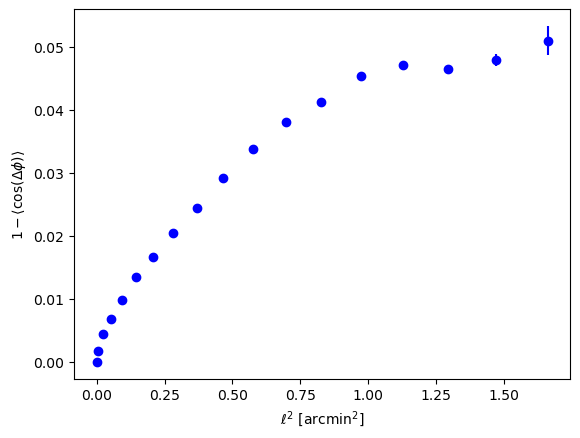

In [9]:
lvec = res1[0][50,50,:]/3600.
disp_f = res1[1][50,50,:]
disp_f_err = res1[2][50,50,:]
plt.errorbar(lvec,disp_f,yerr=disp_f_err,fmt='bo')
plt.xlabel(r'$\ell^{2}$ [arcmin$^{2}$]')
plt.ylabel(r'$1-\langle \cos(\Delta\phi)\rangle$')

And now we fit all the dispersion functions by MCMC and find the maps of paremeters,

In [10]:
lvec = res1[0]
disp_f = res1[1]
disp_f_err = res1[2]
res2 = fitting.mcmc_fit_map(disp_f,lvec,disp_f_err,beam=beam_s,a2=1.0E-3,delta=30.,f=100.,num=200)

# of cores availables = 12


ValueError: Stop argument for islice() must be None or an integer: 0 <= x <= sys.maxsize.

We can use the results to plot the dispersion function,

In [11]:
print(res2)

NameError: name 'res2' is not defined

We can fit dispersion function with the two-scale model, using the mcmc_fit function. For this function it is necessary to specify the maximum value of $\ell^2$ to consider (e.g., where the dispersion function stops being $\ell^{2}$.

Three parameters are obtained from this fitting routine: the large-scale contribution coefficient, $a_{2}$, the turbulence's correlation length, $\delta$, and the product $\Delta^{\prime}[\langle B_{t}^{2}\rangle/\langle B_{0}^{2}\rangle]^{-1}$.

With these values we can plot the fit over the dispersion function for visual confirmation

In [ ]:
def model_funct(x,a,d,f,beam=0.0):
    #
    beam /= 2.355
    dem = d**2 + 2*beam**2
    term = 1./(1. + (dem/(np.sqrt(2*np.pi)*(d**3)))*f)
    return term*( 1-np.exp(-x/(2*dem)) ) + a*x

f = model_funct(l,res3['a'],res3['d'],res3['f'],beam=beam_s)

In [ ]:
# Plot the dispersion function as a function of \ell^2
plt.errorbar(l/3600.,disp_f,yerr=res3['chi']*disp_f_err,fmt='bo')
plt.plot(l/3600., f,c='red')
plt.xlim([0.,10.])
plt.xlabel(r'$\ell^{2}$ [arcmin$^{2}$]')
plt.ylim([0.,0.3])
plt.ylabel(r'$1-\langle \cos(\Delta\phi)\rangle$')

Using the value of $\langle B_{t}^{2}\rangle/\langle B_{0}^{2}\rangle$, along with the reportted values on Butterfield et. al. (2024), the Bpos values can be calculated following the procedures of Tutorial I.